# Комбинация модели Random Forest и байесовских методов
Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.signal import welch, spectrogram
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# 2. Загрузка данных

In [2]:
df = pd.read_csv('final_dataset.csv')  # Убедитесь, что путь к файлу правильный
df.head(6)

,Clean_Signal,Noisy_Signal,Class
0,-0.050548,0.120108,0
1,-0.022422,-0.007673,0
2,0.430269,1.163845,1
3,0.101930,0.100857,0
4,1.462921,2.911377,1
5,0.045052,0.629904,1


# 3. Функция для извлечения признаков

In [3]:
def extract_enhanced_features(signal, fs=1000):
    """Extração de características temporais, frequenciais e wavelet"""
    features = {}

    # 1. Características estatísticas básicas
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })

    # 2. Características frequenciais (método de Welch)
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth',
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency']})

    # 3. Características wavelet
    try:
        coeffs = pywt.wavedec(signal, 'db4', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4)
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)

    return features

def extract_spectrogram_features(signal, fs=1000):
    """Extração de características da espectrograma do sinal"""
    features = {}

    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)

        # Espectro centroids
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })

        # Largura espectral
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })

        # Entropia espectral
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })

        # Planície espectral
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })

        # Energia espectral
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]  # Pico da frequência
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)

    return features

def extract_all_features(signal, fs=1000):
    """Extração de todas as características (temporais, frequenciais, espectrais e wavelet)"""
    signal = ensure_signal_is_sequence(signal)  # Garantir que o sinal seja uma sequência de números
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# 4. Добавление байесовских классов обнаружения в код

In [4]:
class BayesianSignalDetector:
    def __init__(self, noise_std=1.0, signal_std=0.5, prior_signal=0.5):
        self.noise_std = noise_std
        self.signal_std = signal_std
        self.prior_signal = prior_signal
        self.prior_noise = 1 - prior_signal

    def calculate_likelihood(self, x, hypothesis):
        if hypothesis == 'signal':
            return norm.pdf(x, 0, self.signal_std)
        else:  # noise
            return norm.pdf(x, 0, self.noise_std)

    def detect_signal(self, observations):
        posteriors = []
        for x in observations:
            l_signal = self.calculate_likelihood(x, 'signal')
            l_noise = self.calculate_likelihood(x, 'noise')

            # Calculando probabilidades a posteriori
            p_signal = l_signal * self.prior_signal
            p_noise = l_noise * self.prior_noise

            # Normalizando
            total = p_signal + p_noise
            posteriors.append((p_signal/total, p_noise/total))

        return np.array(posteriors)

class AdaptiveBayesianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_detectors=3):
        self.n_detectors = n_detectors
        self.detectors_ = []

    def fit(self, X, y=None):
        if y is None:
            raise ValueError("É necessário passar y ao treinar.")

        # Garantir que os sinais estejam em formato adequado
        noise_signals = X.loc[y==0, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        signal_signals = X.loc[y==1, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]

        noise_params = self._estimate_parameters(noise_signals)
        signal_params = self._estimate_parameters(signal_signals)

        self.detectors_ = []
        for i in range(self.n_detectors):
            noise_std = noise_params[0] * (0.8 + i*0.2)
            signal_std = signal_params[1] * (0.7 + i*0.3)
            prior = 0.3 + i*0.2

            self.detectors_.append(
                BayesianSignalDetector(noise_std=noise_std,
                                       signal_std=signal_std,
                                       prior_signal=prior)
            )
        return self

    def _estimate_parameters(self, signals):
        # Garantir que cada sinal seja tratado como uma sequência, mesmo que seja um número único
        signals = [ensure_signal_is_sequence(s) for s in signals]

        values = np.concatenate([s.flatten() for s in signals])
        std = np.std(values)
        return (std, std*0.7)

    def transform(self, X):
        features = []
        for i, detector in enumerate(self.detectors_):
            signals = X['noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]

            detector_features = signals.apply(
                lambda x: self._extract_detector_features(x, detector, i))
            features.append(pd.DataFrame(detector_features.tolist()))

        return pd.concat(features, axis=1)

    def _extract_detector_features(self, signal, detector, detector_idx):
        signal = ensure_signal_is_sequence(signal)  # Garantir que é uma sequência
        posteriors = detector.detect_signal(signal)
        return {
            f'bayes_{detector_idx}_p_signal_mean': np.mean(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_std': np.std(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_max': np.max(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_min': np.min(posteriors[:, 0]),
            f'bayes_{detector_idx}_snr_ratio': np.mean(posteriors[:, 0]) / (np.mean(posteriors[:, 1]) + 1e-10),
            f'bayes_{detector_idx}_signal_ratio': np.sum(posteriors[:, 0] > 0.5) / len(signal)
        }

# 5. Подготовка данных
- Извлекаются признаки для чистых (Clean_Signal) и зашумленных (Noisy_Signal) сигналов.
- Объединяются в матрицу признаков X.
- Целевая переменная y — это столбец Class.
- Обрабатываются NaN и бесконечные значения.

In [5]:
def ensure_signal_is_sequence(signal):
    if isinstance(signal, str):  # Se for uma string, tenta convertê-la
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)  # Em caso de falha, cria um array de zeros
    elif isinstance(signal, (float, int)):  # Se for um único valor, cria um array
        signal = np.array([signal])
    elif not isinstance(signal, np.ndarray):  # Se não for array, converte para array
        signal = np.array(signal)
    return signal

# Aplicando as funções para extração de características no DataFrame
print("Извлечение признаков из сигналов...")
clean_features = pd.DataFrame(df['Clean_Signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noisy_features = pd.DataFrame(df['Noisy_Signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Adicionando as características bayesianas
bayesian_transformer = AdaptiveBayesianFeatures(n_detectors=3)
X_bayes = bayesian_transformer.fit_transform(df.drop(columns=['Class']), df['Class'])  # Passando y explicitamente

# Combina todas as características
X = pd.concat([clean_features, noisy_features, X_bayes,
               df[['Clean_Signal', 'Noisy_Signal']]], axis=1)
y = df['Class']

# Tratar valores NaN/inf
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)



Извлечение признаков из сигналов...


# 6. Разделение данных и SMOTE
Данные делятся на обучающую и тестовую выборки (80/20). SMOTE используется для устранения дисбаланса классов в обучающих данных.

In [6]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicando SMOTE manualmente no treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 7. Создание пайплайна и GridSearchCV
- Пайплайн включает масштабирование, выбор признаков и случайный лес.
- param_grid задает параметры для перебора.
- Используется стратифицированная 5-кратная кросс-валидация.

In [7]:
# Definindo o pipeline
pipeline = make_pipeline(
    RobustScaler(),
    SelectKBest(score_func=f_classif),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

# Definindo a grade de parâmetros para a busca em grid
param_grid = {
    'selectkbest__k': [15, 20, 25],
    'randomforestclassifier__n_estimators': [200, 250],
    'randomforestclassifier__max_depth': [15, 20, None],
    'randomforestclassifier__min_samples_split': [5, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}

# Estratificação KFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nIniciando a busca GridSearchCV...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv,
                         scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)



Iniciando a busca GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [15, 20, None],
                         'randomforestclassifier__max_features': ['sqrt',
                                                                  'log2'],
                         'randomforestclassifier__min_samples_split': [5, 10],
                         'randomforestclassifier__n_estimators': [200, 250],
                         'selectkbest__k': [15, 20, 25]},
             scoring='roc_auc', verbose=2)

# 8. Оценка модели
Выводятся лучшие параметры и отчет о классификации.

In [8]:
# Melhor modelo
best_model = grid_search.best_estimator_
print("\nMelhores parâmetros:", grid_search.best_params_)

# Predição no conjunto de teste
y_pred = best_model.predict(X_test)

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Melhores parâmetros: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200, 'selectkbest__k': 25}

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       113
           1       0.98      0.97      0.98       115

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228



# 9. Матрица ошибок
Выводятся лучшие параметры и отчет о классификации.

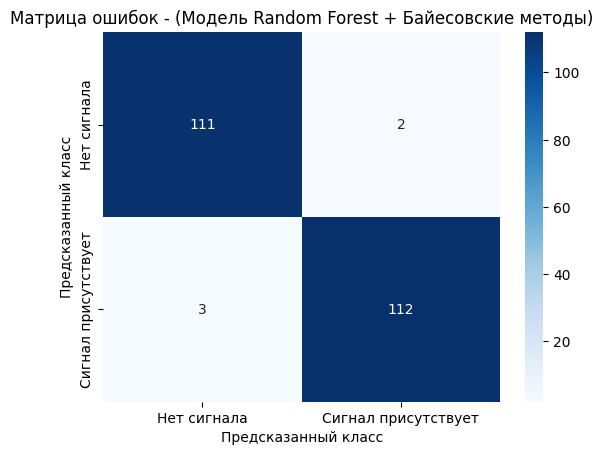

In [10]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Нет сигнала', 'Сигнал присутствует'], yticklabels=['Нет сигнала', 'Сигнал присутствует'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Предсказанный класс')
plt.title('Матрица ошибок - (Модель Random Forest + Байесовские методы)')
plt.show()